In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def graphite_LGM50_lithiation_ocp_OKane2023(sto):
    u_eq = (
        0.5476 * pybamm.exp(-422.4 * sto)
        + 0.5705 * pybamm.exp(-36.89 * sto)
        + 0.1336
        - 0.04758 * pybamm.tanh(13.88 * (sto - 0.2101))
        - 0.01761 * pybamm.tanh(36.2 * (sto - 0.5639))
        - 0.0169 * pybamm.tanh(11.42 * (sto - 1))
    )

    return u_eq


def nmc_LGM50_delithiation_ocp_OKane2023(sto):
    U = (
        -0.7836 * sto
        + 4.513
        - 0.03432 * pybamm.tanh(19.83 * (sto - 0.5424))
        - 19.35 * pybamm.tanh(14.33 * (sto - 0.2771))
        + 19.17 * pybamm.tanh(14.45 * (sto - 0.2776))
    )

    return U

In [3]:
model = pybamm.lithium_ion.DFN(options={
    "SEI": "constant",
    "SEI porosity change": "true",
    "SEI on cracks": "true",
    "particle mechanics": "constant cracks",
    "contact resistance": "true",
})

param = pybamm.ParameterValues("OKane2023")
param.update({"Negative electrode OCP [V]": graphite_LGM50_lithiation_ocp_OKane2023})
param.update({"Positive electrode OCP [V]": nmc_LGM50_delithiation_ocp_OKane2023})

exp1 = pybamm.Experiment(["Discharge at 1 A until 2.5V (5 minute period)", "Rest for 4 hours (5 minute period)"])

exp2 = pybamm.Experiment(
    [("Rest for 120 seconds (1 second period)", "Charge at 0.5C for 360 seconds or until 4.2V (0.1 second period)", 
    "Rest for 2 hours (1 second period)")] * 20,
)

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 200,  # negative particle
    "r_p": 100,  # positive particle
}

sim1 = pybamm.Simulation(model, parameter_values=param, experiment=exp1, var_pts=var_pts)
sol1 = sim1.solve(calc_esoh=False)
model.set_initial_conditions_from(sol1)
sim2 = pybamm.Simulation(model, parameter_values=param, experiment=exp2, var_pts=var_pts)
sol2 = sim2.solve(calc_esoh=False)

At t = 0.00632999 and h = 2.16889e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00632999 and h = 9.27543e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00632999 and h = 9.74627e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00293157 and h = 6.29275e-18, the corrector convergence failed repeatedly or with |h| = hmin.


In [4]:
t_seconds = sol2["Time [s]"].entries
t_hours = (t_seconds - 120) / 3600
I = sol2["Current [A]"].entries
Q = sol2["Discharge capacity [A.h]"].entries
V = sol2["Terminal voltage [V]"].entries

In [5]:
# import experimental GITT data from files
GITT_data = pd.read_csv(
    "/mnt/c/Users/sokane/pybamm_data/validation_data/NDK01-78 - 0,5C GITT charge - cell 1_CD1.mpt",
    encoding = "shift-jis",
    sep = "\t",
    skiprows = lambda x: x in range(29323)
).to_numpy()
t_exp_1 = GITT_data[:,8]/3600
I_exp_1 = -GITT_data[:,11]/1000
V_exp_1 = GITT_data[:,10]
Q_exp_1 = []
for i in range (len(t_exp_1)):
    Q_temp = np.trapz(I_exp_1[0:i],t_exp_1[0:i])
    Q_exp_1.append(Q_temp)
GITT_data = pd.read_csv(
    "/mnt/c/Users/sokane/pybamm_data/validation_data/NDK01-78 - 0,5C GITT charge - cell 2_CD2.mpt",
    encoding = "shift-jis",
    sep = "\t",
    skiprows = lambda x: x in range(29248)
).to_numpy()
t_exp_2 = GITT_data[:,8]/3600
I_exp_2 = -GITT_data[:,11]/1000
V_exp_2 = GITT_data[:,10]
Q_exp_2 = []
for i in range (len(t_exp_2)):
    Q_temp = np.trapz(I_exp_2[0:i],t_exp_2[0:i])
    Q_exp_2.append(Q_temp)
GITT_data = pd.read_csv(
    "/mnt/c/Users/sokane/pybamm_data/validation_data/NDK01-78 - 0,5C GITT charge - cell 3_CD3.mpt",
    encoding = "shift-jis",
    sep = "\t",
    skiprows = lambda x: x in range(29379)
).to_numpy()
t_exp_3 = GITT_data[:,8]/3600
I_exp_3 = -GITT_data[:,11]/1000
V_exp_3 = GITT_data[:,10]
Q_exp_3 = []
for i in range (len(t_exp_3)):
    Q_temp = np.trapz(I_exp_3[0:i],t_exp_3[0:i])
    Q_exp_3.append(Q_temp)

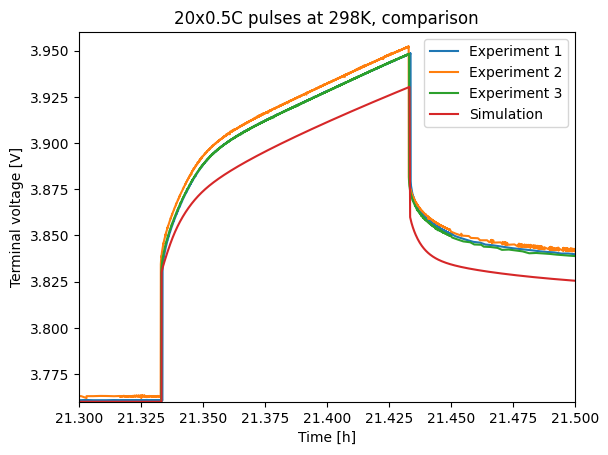

In [20]:
fig, ax = plt.subplots()
ax.plot(t_exp_1-t_exp_1[0],V_exp_1,label='Experiment 1')
ax.plot(t_exp_2-t_exp_2[0],V_exp_2,label='Experiment 2')
ax.plot(t_exp_3-t_exp_3[0],V_exp_3,label='Experiment 3')
ax.plot(t_hours,V,label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('20x0.5C pulses at 298K, comparison')
ax.legend()
plt.xlim(21.3,21.5)
plt.ylim(3.76,3.96)
plt.savefig('/mnt/c/Users/sokane/pybamm_data/validation_data/GITT_0point5C_charge_with_hysteresis_zoomed.png')
plt.show()